In [1]:
import scipy.io
import pandas as pd

mat1 = scipy.io.loadmat('data.mat')

In [2]:
df = pd.DataFrame(mat1['data']).T

In [3]:
mat2 = scipy.io.loadmat('label.mat')

In [4]:
label = pd.DataFrame(mat2['trueLabel']).T

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

data = df.to_numpy()

In [6]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_data = pca.fit_transform(data)
pca_data.shape

(1990, 5)

In [7]:
def initialize_clusters(X, n_clusters):
    clusters = []
    
    for i in range(n_clusters):
        cluster_i = {'pi': 1.0/n_clusters, 
                     'mu': np.random.normal(0, 0.1, X.shape[1]), 
                     'cov':np.identity(X.shape[1], dtype=np.float64)
                     }
        clusters.append(cluster_i)
    return clusters

In [8]:
#from scipy.stats import multivariate_normal

def gaussian(X, mu, cov):
    w, v = np.linalg.eig(cov)
    ww = w.real[:] 
    vv = v.real[:, :]
    xx = X.dot(vv)
    mu = mu.reshape(1, -1).dot(vv)
    
    return (1 / (np.prod(list(ww))**0.5) * np.exp(-0.5 * np.sum((xx-mu)**2/ww.reshape(1,-1), axis=1))).reshape(-1, 1)
    #return multivariate_normal.pdf(X, mu, vv.dot(np.diag(list(ww))).dot(vv.T)).reshape(-1, 1)

In [9]:
def expectation(X, clusters):
    
    mixture = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi = cluster['pi']
        mu = cluster['mu']
        cov = cluster['cov']
        tau = (pi * gaussian(X, mu, cov)).astype(np.float64)
        #tau = multivariate_normal.pdf(X, mu, cov).reshape(-1,1)
        
        for i in range(X.shape[0]):
            mixture[i] += tau[i]
        
        cluster['tau'] = tau
        cluster['mixture'] = mixture
    
    for cluster in clusters:
        cluster['tau'] /= cluster['mixture']
        

In [10]:
def maximization(X, clusters):
    
    m, n = X.shape
    
    for cluster in clusters:
        tau = cluster['tau']
        cov = np.zeros((n, n), dtype=np.float64)
        pi = np.sum(tau, axis=0) / m
        mu = np.sum(tau * X, axis=0) / np.sum(tau, axis=0)
        
        for i in range(m):
            d = (X[i] - mu).reshape(-1,1)
            cov += tau[i] * np.dot(d, d.T)
        
        cov /= np.sum(tau, axis=0)
        
        cluster['pi'] = pi
        cluster['mu'] = mu
        cluster['cov'] = cov

In [11]:
def likelihood(X, clusters):
    likelihoods = np.log(np.array([cluster['mixture'] for cluster in clusters]))
    return np.sum(likelihoods)

In [12]:
def GMM(X, n_clusters, n_iteration):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros(n_iteration)
    
    for i in range(n_iteration):
        new_cluster = []
        
        #for cluster in clusters:
            #new_cluster.append()
            
        expectation(X, clusters)
        maximization(X, clusters)
        likelihoods[i] = likelihood(X, clusters)
        
    return clusters, likelihoods

In [13]:
n_clusters = 2
n_iteration = 20
clusters, likelihoods = GMM(pca_data, n_clusters, n_iteration)

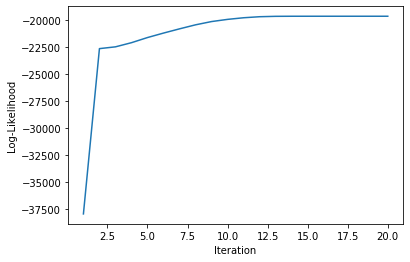

In [14]:
plt.figure
plt.plot(np.arange(1, n_iteration+1), likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.show()

In [15]:
pi1 = clusters[0]['pi']
pi2 = clusters[1]['pi']
print('weight of 1st component:', pi1)
print('weight of 2nd component:', pi2)

weight of 1st component: [0.50685883]
weight of 2nd component: [0.49314117]


In [19]:
label = label.to_numpy()
n_2 = len(label[label[:, 0] == 2])
n_2 

1032

In [20]:
n_6 = len(label[label[:, 0] == 6])
n_6

958

In [22]:
print('GMM mis-classification rate of digit "2":', float(abs(data.shape[0]*pi1 - n_2) / n_2))
print('GMM mis-classification rate of digit "6":', float(abs(data.shape[0]*pi2 - n_6) / n_6))

GMM mis-classification rate of digit "2": 0.02262687413391279
GMM mis-classification rate of digit "6": 0.024374670256991766
